# 8. Accuracy best model on 2017 data:

     Vamos a utilizar el modelo SVM optimizado en los datos de 2017.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
%matplotlib inline
matplotlib.style.use("ggplot")

In [2]:
pd.set_option('display.max_columns', None)

## 8.1. Lanzamos el proceso de limpieza generado anteriormente:

### 1. File loading and examine:

     Vamos a utilizar los data sets del año 2017. Suprimimos todos los comentarios sobre el proceso al ser una replica exacta del creado anteriormente.

In [91]:
frame = pd.read_csv('../tennis_atp-master/atp_matches_2017.csv')

In [92]:
# 1. Take out matchs from Davies Cup:
framesD = frame[frame['tourney_level'] != 'D']
# 2. Take out matchs from Challenge CUP:
framesDC = framesD[framesD['tourney_level'] != 'C']
# 3.1. Take out marchs'W/O' (Walk Over):
framesDCWO = framesDC[framesDC['score'] != 'W/O']
# 3.2. Take out marchs' W/O' (Walk Over):
framesDCWO = framesDCWO[framesDCWO['score'] != ' W/O']
# 4. Take out matchs with high volume of NaNs:
framesDCWO2 = framesDCWO.dropna(axis=0, thresh=30)

In [93]:
x = frame.shape
y = framesDCWO2.shape
Limpieza = x[0] - y[0]
Limpieza2 = (float(Limpieza) / float(x[0]))
print "    Hemos eliminado %d partidos sobre un total de %d, lo que supone un %f " %((Limpieza), x[0], (Limpieza2))


    Hemos eliminado 127 partidos sobre un total de 388, lo que supone un 0.327320 


In [94]:
columns = ['winner_seed', 'loser_seed', 'winner_entry', 'loser_entry']
framesDCWO2.drop(columns, inplace=True, axis=1) 
framesDCWO2['TotalGames'] = framesDCWO2['w_SvGms'] + framesDCWO2['l_SvGms']
framesDCWO2.shape

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(261, 46)

### 2. New Feature creation: Retired.

In [95]:
Retired = []
for row in framesDCWO2['score']:
    if 'RET' in row:
        # Append 1
        Retired.append(1)
    # else, if not append 0,
    else:
        Retired.append(0)
# Create a column from the list
framesDCWO2['Retired'] = Retired

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [96]:
Ret = framesDCWO2[framesDCWO2['Retired'] == 1 ]
Ret.shape

(9, 47)

In [97]:
print """     El data set tiene %d partidos no terminados por Retired sobre un total de %d,
   lo que supone un %f""" %(len(Ret.index),len(framesDCWO2.index), (float(len(Ret.index))/float(len(framesDCWO2.index))))

     El data set tiene 9 partidos no terminados por Retired sobre un total de 261,
   lo que supone un 0.034483


     El porcentaje de retired es similar al obtenido en el data set de 2000 a 2016

In [98]:
framesDCWO2 = framesDCWO2[framesDCWO2['Retired'] != 1]
framesDCWO2.shape

(252, 47)

### 3. New feature creation: Hand (1 - Right hand, 0 - Left Hand)

In [99]:
Hand = {'R': 1,'L': 0}
framesDCWO2["w_hand"] = np.nan
framesDCWO2["l_hand"] = np.nan
framesDCWO2['w_hand'] = framesDCWO2['w_hand'].fillna(framesDCWO2['winner_hand'].map(Hand))
framesDCWO2['l_hand'] = framesDCWO2['l_hand'].fillna(framesDCWO2['loser_hand'].map(Hand))

### 4. New feature creation: Best of (1 - 3 sets, 0 - 5 sets)

In [100]:
Sets = {'5': 1,'3': 0}
framesDCWO2['best_of'] = framesDCWO2['best_of'].astype(str)
framesDCWO2['Total_Sets'] = np.nan
framesDCWO2['Total_Sets'] = framesDCWO2['Total_Sets'].fillna(framesDCWO2['best_of'].map(Sets))
framesDCWO2['Total_Sets'] = framesDCWO2['Total_Sets'].astype(int)

### 5. Solve *_ht (height) problem:

In [102]:
framesDCWO2.isnull().sum()

tourney_id             0
tourney_name           0
surface                0
draw_size              0
tourney_level          0
tourney_date           0
match_num              0
winner_id              0
winner_name            0
winner_hand            0
winner_ht             58
winner_ioc             0
winner_age             0
winner_rank            0
winner_rank_points     0
loser_id               0
loser_name             0
loser_hand             0
loser_ht              92
loser_ioc              0
loser_age              0
loser_rank             1
loser_rank_points      1
score                  0
best_of                0
round                  0
minutes                0
w_ace                  0
w_df                   0
w_svpt                 0
w_1stIn                0
w_1stWon               0
w_2ndWon               0
w_SvGms                0
w_bpSaved              0
w_bpFaced              0
l_ace                  0
l_df                   0
l_svpt                 0
l_1stIn                0


In [126]:
w_Names = {'Adrian Cruciat': 185,
 'Alejandro Gonzalez': 191,
 'Aleksandr Nedovyesov': 193,
 'Alexander Zverev': 191,
 'Alexandre Sidorenko': 185,
 'Ante Pavic': 196,
 'Augustin Gensse': 180,
 'Austin Krajicek': 188,
 'Axel Michon': 176,
 'Bastian Knittel': 180,
 'Blaz Rola': 193,
 'Borna Coric': 185,
 'Chris Eaton': 188,
 'Christian Garin': 185,
 'Christian Harrison': 180,
 'Christian Lindell': 193,
 'Chuhan Wang': 188,
 'Daniel Kosakowski': 185,
 'Daniel Munoz De La Nava': 178,
 'Dennis Novikov': 193,
 'Diego Sebastian Schwartzman': 170,
 'Dimitar Kutrovsky': 175,
 'Dominic Thiem': 185,
 'Elias Ymer': 183,
 'Emilio Gomez': 185,
 'Facundo Bagnis': 183,
 'Filip Peliwo': 178,
 'Gianluca Naso': 193,
 'Guido Pella': 185,
 'Guillermo Olaso': 175,
 'Gustavo Marcaccio': 170,
 'Henri Kontinen': 191,
 'Henri Laaksonen': 185,
 'Hiroki Kondo': 178,
 'Hiroki Moriya': 170,
 'Inigo Cervantes Huegun': 183,
 'Ivan Sergeyev': 175,
 'Jamie Baker': 183,
 'Jan Lennard Struff': 196,
 'Jaroslav Pospisil': 178,
 'Jason Kubler': 178,
 'Javier Marti': 185,
 'Jiri Vesely': 198,
 'Joao Sousa': 185,
 'Jonathan Dasnieres De Veigy': 175,
 'Jonathan Marray': 183,
 'Jorge Aguilar': 178,
 'Karen Khachanov': 198,
 'Kyle Edmund': 188,
 'Laurent Recouderc': 178,
 'Leonardo Tavares': 185,
 'Lucas Pouille': 185,
 'Luka Gregorc': 190,
 'Luke Saville': 188,
 'Marco Trungelliti': 180,
 'Martin Alund': 183,
 'Martin Fischer': 180,
 'Marton Fucsovics': 188,
 'Mate Delic': 196,
 'Mate Pavic': 193,
 'Mathieu Rodrigues': 180,
 'Matteo Viola': 185,
 'Maxime Teixeira': 188,
 'Miloslav Mecir': 196,
 'Mirza Basic': 188,
 'Nick Kyrgios': 193,
 'Nikola Milojevic': 188,
 'Nils Langer': 193,
 'Pablo Carreno Busta': 188,
 'Patrik Rosenholm': 178,
 'Pavol Cervenak': 191,
 'Peng Sun': 184,
 'Petar Jelenic': 190,
 'Philip Davydenko': 183,
 'Philipp Oswald': 201,
 'Pierre Hugues Herbert': 188,
 'Pierre Ludovic Duclos': 188,
 'Radu Albot': 175,
 'Rafael Arevalo': 180,
 'Ramkumar Ramanathan': 188,
 'Renzo Olivo': 180,
 'Rhyne Williams': 185,
 'Roberto Bautista Agut': 183,
 'Roberto Carballes Baena': 180,
 'Ruben Bemelmans': 183,
 'Samuel Groth': 193,
 'Sebastian Rieschick': 188,
 'Sergei Bubka': 188,
 'Takahiro Terachi': 174,
 'Taro Daniel': 191,
 'Thanasi Kokkinakis': 196,
 'Tim Puetz': 185,
 'Yan Bai': 185,
 'Yannick Mertens': 188,
 'Yuichi Sugita': 175,
 'Ze Zhang': 188,
 'Jordan Thompson': 183,
 'Jared Donaldson': 188,
 'Daniil Medvedev': 198,
 'Alex Minaur': 180,
 'Alex De Minaur': 180,
 'Ernesto Escobedo': 185,
 'Yoshihito Nishioka': 170,
 'Jozef Kovalik': 183,
 'Alexander Bublik': 196,
 'Andrew Whittington': 188,
 'Artem Sitak': 185,
 'Hyeon Chung': 188,
 'Finn Tearney': 183,
 'Saketh Myneni': 193,
 'Reilly Opelka': 211,
 'Gerald Melzer': 188,
 'Nikola Mektic': 183,
 'Arthur De Greef': 183,
 'Michael Mmoh': 185,
 'Thiago Monteiro': 183,
 'Francis Tiafoe': 188,
 'Adam Pavlasek': 185,
 'Casper Ruud': 183,
 'Michael Venus': 191,
 'Nikoloz Basilashvili': 185,
 'Andrey Rublev': 188,
 'Omar Jasika': 183,
 'Matthew Barton': 191,
 'Alex Bolt': 183,}

In [127]:
framesDCWO2['winner_ht'] = framesDCWO2['winner_ht'].fillna(framesDCWO2['winner_name'].map(w_Names))
framesDCWO2['loser_ht'] = framesDCWO2['loser_ht'].fillna(framesDCWO2['loser_name'].map(w_Names))

    1. Limpiar de NaNs:

In [129]:
framesDCWO2 = framesDCWO2.dropna()

In [130]:
framesDCWO2.shape

(240, 50)

    2. Buscar 0 en aquellas variables que puedan tenerlos para evitar generar Infinitos:

In [131]:
framesDCWO2[framesDCWO2['w_SvGms'] == 0]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets


In [132]:
framesDCWO2[framesDCWO2['l_SvGms'] == 0]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets


### 6. Average minutes per game:

In [135]:
framesDCWO2 = framesDCWO2.sort_values(by=['tourney_date', 'match_num'])

In [136]:
framesDCWO2 = framesDCWO2.set_index('tourney_date','match_num').sort_index()

In [137]:
framesDCWO2['w_minutes_cum']=framesDCWO2.groupby('winner_name')['minutes'].transform(pd.Series.cumsum)
framesDCWO2['w_TotalGames_cum']=framesDCWO2.groupby('winner_name')['TotalGames'].transform(pd.Series.cumsum)
framesDCWO2['w_minutes_average'] = framesDCWO2['w_minutes_cum'] / framesDCWO2['w_TotalGames_cum']
columns = ['w_minutes_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

In [138]:
framesDCWO2['l_minutes_cum']=framesDCWO2.groupby('loser_name')['minutes'].transform(pd.Series.cumsum)
framesDCWO2['l_TotalGames_cum']=framesDCWO2.groupby('loser_name')['TotalGames'].transform(pd.Series.cumsum)
framesDCWO2['l_minutes_average'] = framesDCWO2['l_minutes_cum'] / framesDCWO2['l_TotalGames_cum']
columns = ['l_minutes_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

### 7. Average aces per game

In [139]:
framesDCWO2['w_aces_cum']=framesDCWO2.groupby('winner_name')['w_ace'].transform(pd.Series.cumsum)
framesDCWO2['w_aces_average'] = framesDCWO2['w_aces_cum'] / framesDCWO2['w_TotalGames_cum']
framesDCWO2['l_aces_cum']=framesDCWO2.groupby('loser_name')['l_ace'].transform(pd.Series.cumsum)
framesDCWO2['l_aces_average'] = framesDCWO2['l_aces_cum'] / framesDCWO2['l_TotalGames_cum']
columns = ['w_aces_cum', 'l_aces_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

### 8. Average double foult per match

In [140]:
framesDCWO2['w_df_cum']=framesDCWO2.groupby('winner_name')['w_df'].transform(pd.Series.cumsum)
framesDCWO2['w_df_average'] = framesDCWO2['w_df_cum'] / framesDCWO2['w_TotalGames_cum']
framesDCWO2['l_df_cum']=framesDCWO2.groupby('loser_name')['l_df'].transform(pd.Series.cumsum)
framesDCWO2['l_df_average'] = framesDCWO2['l_df_cum'] / framesDCWO2['l_TotalGames_cum']
columns = ['w_df_cum', 'l_df_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

### 9. % First In (w_1stIn/game)

In [141]:
framesDCWO2['w_1stIn_cum']=framesDCWO2.groupby('winner_name')['w_1stIn'].transform(pd.Series.cumsum)
framesDCWO2['w_SvGames_cum']=framesDCWO2.groupby('winner_name')['w_SvGms'].transform(pd.Series.cumsum)
framesDCWO2['w_1stIn_average'] = framesDCWO2['w_1stIn_cum'] / framesDCWO2['w_SvGames_cum']
framesDCWO2['l_1stIn_cum']=framesDCWO2.groupby('loser_name')['l_1stIn'].transform(pd.Series.cumsum)
framesDCWO2['l_SvGames_cum']=framesDCWO2.groupby('loser_name')['l_SvGms'].transform(pd.Series.cumsum)
framesDCWO2['l_1stIn_average'] = framesDCWO2['l_1stIn_cum'] / framesDCWO2['l_SvGames_cum']
columns = ['w_1stIn_cum', 'l_1stIn_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

In [142]:
x = framesDCWO2[framesDCWO2['winner_name'] == 'Rafael Nadal']['w_1stIn_average'].mean()
y = framesDCWO2[framesDCWO2['loser_name'] == 'Rafael Nadal']['l_1stIn_average'].mean()
print (x,y)

(3.94518666749397, 4.553571428571429)


### 10. % First Won (w_1stWon/game)

In [143]:
framesDCWO2['w_1stWon_cum']=framesDCWO2.groupby('winner_name')['w_1stWon'].transform(pd.Series.cumsum)
framesDCWO2['w_1stWon_average'] = framesDCWO2['w_1stWon_cum'] / framesDCWO2['w_SvGames_cum']
framesDCWO2['l_1stWon_cum']=framesDCWO2.groupby('loser_name')['l_1stWon'].transform(pd.Series.cumsum)
framesDCWO2['l_1stWon_average'] = framesDCWO2['l_1stWon_cum'] / framesDCWO2['l_SvGames_cum']
columns = ['w_1stWon_cum', 'l_1stWon_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

### 11. % Second Won (w_2ndWon/game)

In [144]:
framesDCWO2['w_2ndWon_cum']=framesDCWO2.groupby('winner_name')['w_2ndWon'].transform(pd.Series.cumsum)
framesDCWO2['w_2ndWon_average'] = framesDCWO2['w_2ndWon_cum'] / framesDCWO2['w_SvGames_cum']
framesDCWO2['l_2ndWon_cum']=framesDCWO2.groupby('loser_name')['l_2ndWon'].transform(pd.Series.cumsum)
framesDCWO2['l_2ndWon_average'] = framesDCWO2['l_2ndWon_cum'] / framesDCWO2['l_SvGames_cum']
columns = ['w_2ndWon_cum', 'l_2ndWon_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

### 12. % Break Point Saved (w_bpSaved/w_bpFaced)

In [145]:
framesDCWO2['w_bpSaved_cum']=framesDCWO2.groupby('winner_name')['w_bpSaved'].transform(pd.Series.cumsum)
framesDCWO2['w_bpFaced_cum']=framesDCWO2.groupby('winner_name')['w_bpFaced'].transform(pd.Series.cumsum)
framesDCWO2['w_bpSaved_average'] = framesDCWO2['w_bpSaved_cum'] / framesDCWO2['w_bpFaced_cum']
framesDCWO2['l_bpSaved_cum']=framesDCWO2.groupby('loser_name')['l_bpSaved'].transform(pd.Series.cumsum)
framesDCWO2['l_bpFaced_cum']=framesDCWO2.groupby('loser_name')['l_bpFaced'].transform(pd.Series.cumsum)
framesDCWO2['l_bpSaved_average'] = framesDCWO2['l_bpSaved_cum'] / framesDCWO2['l_bpFaced_cum']
columns = ['w_bpSaved_cum','w_bpFaced_cum', 'l_bpSaved_cum', 'l_bpFaced_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

## 3.2. Data Transformation:

#### 1. Creating new Features: Dif

In [146]:
framesDCWO2 = framesDCWO2.reset_index()

#### 1.1.1. dif_Minutes

In [147]:
framesDCWO2['dif_Minutes'] = framesDCWO2['w_minutes_average'] - framesDCWO2['l_minutes_average'] 
framesDCWO2.loc[1::2,'dif_Minutes'] = - framesDCWO2['w_minutes_average'] + framesDCWO2['l_minutes_average'] 

#### 1.1.2. dif_Aces

In [148]:
framesDCWO2['dif_Aces'] = framesDCWO2['w_aces_average'] - framesDCWO2['l_aces_average'] 
framesDCWO2.loc[1::2,'dif_Aces'] = - framesDCWO2['w_aces_average'] + framesDCWO2['l_aces_average'] 

#### 1.1.3. dif_Df

In [149]:
framesDCWO2['dif_Df'] = framesDCWO2['w_df_average'] - framesDCWO2['l_df_average'] 
framesDCWO2.loc[1::2,'dif_Df'] = - framesDCWO2['w_df_average'] + framesDCWO2['l_df_average'] 

#### 1.1.4. dif_1stIn

In [150]:
framesDCWO2['dif_1stIn'] = framesDCWO2['w_1stIn_average'] - framesDCWO2['l_1stIn_average'] 
framesDCWO2.loc[1::2,'dif_1stIn'] = - framesDCWO2['w_1stIn_average'] + framesDCWO2['l_1stIn_average'] 

#### 1.1.5. dif_1stWon

In [151]:
framesDCWO2['dif_1stWon'] = framesDCWO2['w_1stWon_average'] - framesDCWO2['l_1stWon_average'] 
framesDCWO2.loc[1::2,'dif_1stWon'] = - framesDCWO2['w_1stWon_average'] + framesDCWO2['l_1stWon_average'] 

#### 1.1.6. dif_2ndWon

In [152]:
framesDCWO2['dif_2ndWon'] = framesDCWO2['w_2ndWon_average'] - framesDCWO2['l_2ndWon_average'] 
framesDCWO2.loc[1::2,'dif_2ndWon'] = - framesDCWO2['w_2ndWon_average'] + framesDCWO2['l_2ndWon_average'] 

#### 1.1.7. dif_BpSv

In [153]:
framesDCWO2['dif_BpSv'] = framesDCWO2['w_bpSaved_average'] - framesDCWO2['l_bpSaved_average'] 
framesDCWO2.loc[1::2,'dif_BpSv'] = - framesDCWO2['w_bpSaved_average'] + framesDCWO2['l_bpSaved_average'] 

#### 1.1.8. dif_Age

In [154]:
framesDCWO2['dif_Age'] = framesDCWO2['winner_age'] - framesDCWO2['loser_age'] 
framesDCWO2.loc[1::2,'dif_Age'] = - framesDCWO2['winner_age'] + framesDCWO2['loser_age'] 

#### 1.1.9. dif_Height

In [155]:
framesDCWO2['dif_Height'] = framesDCWO2['winner_ht'] - framesDCWO2['loser_ht'] 
framesDCWO2.loc[1::2,'dif_Height'] = - framesDCWO2['winner_ht'] + framesDCWO2['loser_ht'] 

#### 1.1.10. dif_Rank

In [156]:
framesDCWO2['dif_Rank'] = framesDCWO2['winner_rank'] - framesDCWO2['loser_rank'] 
framesDCWO2.loc[1::2,'dif_Rank'] = - framesDCWO2['winner_rank'] + framesDCWO2['loser_rank'] 

#### 1.1.11. dif_RankP

In [157]:
framesDCWO2['dif_RankP'] = framesDCWO2['winner_rank_points'] - framesDCWO2['loser_rank_points'] 
framesDCWO2.loc[1::2,'dif_RankP'] = - framesDCWO2['winner_rank_points'] + framesDCWO2['loser_rank_points'] 

## TARGET:

In [158]:
framesDCWO2['Y'] = 1
framesDCWO2.loc[1::2,'Y'] = 0

    Generamos el dataframe definitivo incluyendo todas las features que vamos a utilizar:

In [159]:
TennisDF = framesDCWO2[['Y','dif_Rank','dif_RankP','dif_Height','dif_Age','w_hand','l_hand','dif_Minutes','dif_Aces',
                        'dif_Df','dif_1stIn','dif_1stWon', 'dif_2ndWon','dif_BpSv']]             

In [160]:
TennisDF.shape

(240, 14)

In [162]:
TennisDF = TennisDF.dropna()

In [163]:
TennisDF.shape

(233, 14)

**Antes de seguir vamos a hacer una copia de este DataSet. Esta será nuestra base para todos los trabajos posteriores:**

In [166]:
TennisDF.to_csv('TennisDF_2017', encoding='utf-8', index=False)

## 8.2. Data Analisis:

### 8.2.1. Feature distribution:

    Vamos a analizar visualmente la distribución de de nuestras variables:

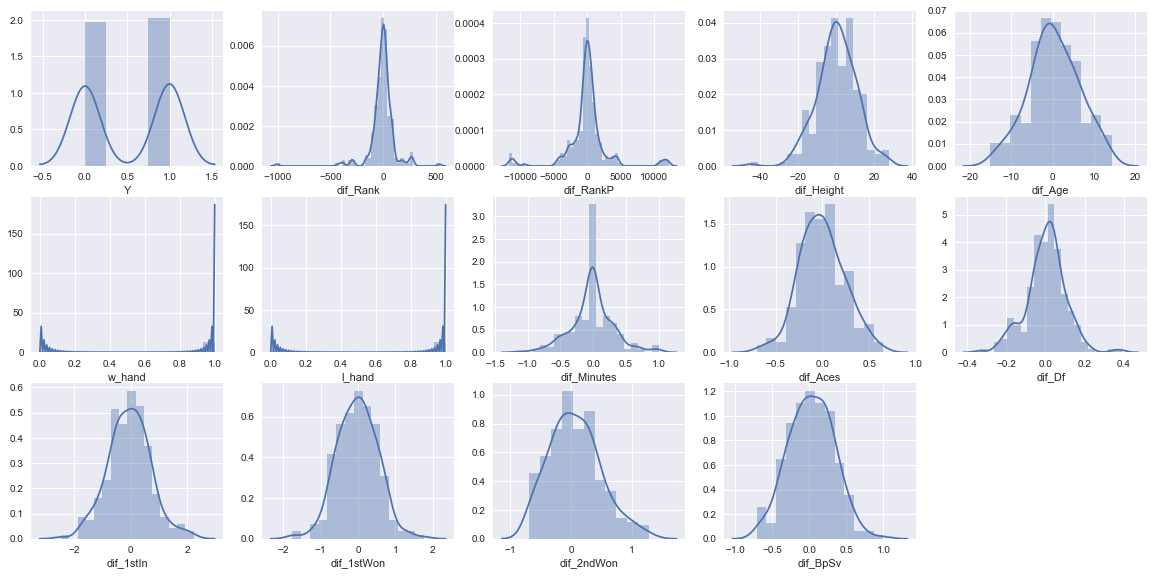

In [170]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
for index,col in enumerate(TennisDF.columns):
    plt.subplot(6,5,index+1)
    sns.distplot(TennisDF[col])

     Antes de introducir las variables en el modelo vamos a estandarizarlas:

   **METODO 1:**

In [171]:
TennisDF_X = TennisDF[['dif_Rank','dif_RankP','dif_Height','dif_Age','w_hand','l_hand','dif_Minutes','dif_Aces',
                        'dif_Df','dif_1stIn','dif_1stWon', 'dif_2ndWon','dif_BpSv']]
TennisDF_Y = TennisDF['Y']

In [172]:
TennisDFnorm_X = TennisDF_X.apply(lambda x: (x - np.mean(x)) / (np.std(x)))

In [173]:
TennisDFnorm_X.head()

,dif_Rank,dif_RankP,dif_Height,dif_Age,w_hand,l_hand,dif_Minutes,dif_Aces,dif_Df,dif_1stIn,dif_1stWon,dif_2ndWon,dif_BpSv
0,-0.457522,3.482508,-0.796784,0.424275,0.362033,0.462106,0.050856,-0.976288,1.387396,0.301245,1.777292,-1.760194,0.056955
1,0.646735,-0.237244,-2.222673,-1.623791,0.362033,-2.164007,0.050856,-2.067429,-1.848408,1.037939,-0.307413,1.354620,0.789579
2,0.094606,0.004478,-0.226429,0.991570,0.362033,0.462106,0.050856,1.241006,0.549894,-1.881841,-0.845787,0.540289,-0.913772
3,-0.122899,0.065933,0.153808,0.201378,-2.762178,0.462106,0.050856,0.628333,-0.329484,0.071783,0.250901,-0.719378,-0.089570
4,-0.750317,0.184746,0.248868,0.189317,0.362033,0.462106,0.050856,0.015659,-0.451619,-2.031619,-0.279165,-1.745773,-0.858825


     Vuelvo a visualizar las variables predictoras para ver si están contenidas entre su media y 3 veces su desviación estandar:

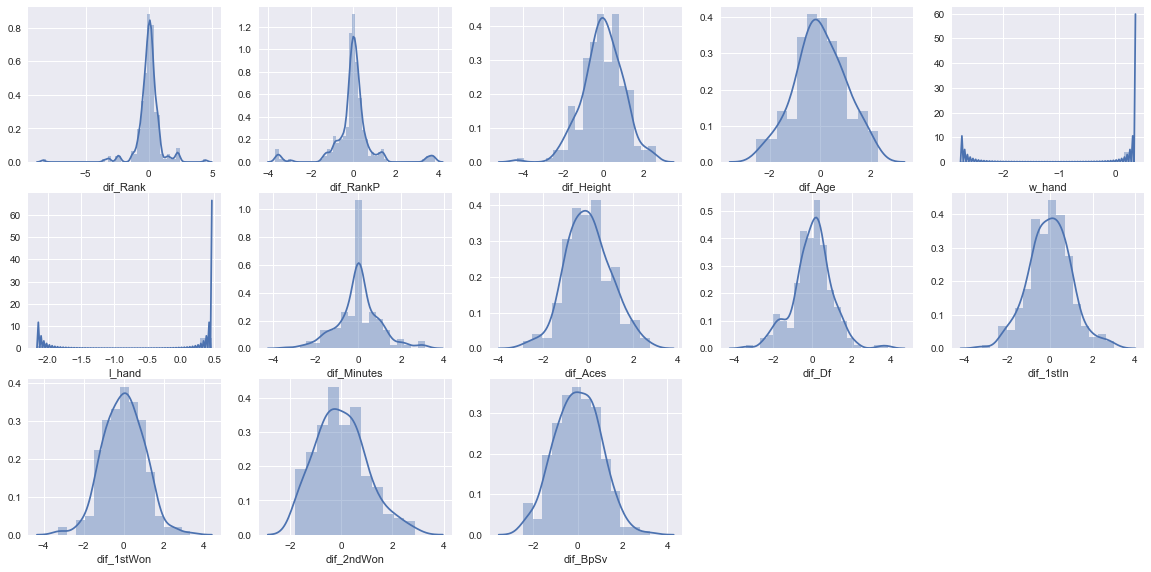

In [174]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
for index,col in enumerate(TennisDFnorm_X.columns):
    plt.subplot(6,5,index+1)
    sns.distplot(TennisDFnorm_X[col])

# 8.3. Modeling the data:

In [178]:
X = TennisDFnorm_X[['dif_Rank']]
y = TennisDF['Y']

###       Analisis de la Colinearidad:

In [214]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

    1. First In:

In [188]:
X = TennisDFnorm_X[['dif_1stIn']]

In [189]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.38461538,  0.5       ,  0.66666667,  0.45454545,  0.45454545])

     OK, no existe una correlación importante con el resultado.

    2. Second Won:

In [190]:
X = TennisDFnorm_X[['dif_2ndWon']]

In [191]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.84615385,  0.66666667,  0.91666667,  0.90909091,  0.63636364])

     Existe una correalción fuerte. Deberíamos rechazarla en el modelo.

    3. First Won:

In [192]:
X = TennisDFnorm_X[['dif_1stWon']]

In [193]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.76923077,  0.83333333,  0.83333333,  0.81818182,  0.81818182])

     Existe una correalción fuerte. Deberíamos rechazarla en el modelo.

    4. Break Points saved:

In [194]:
X = TennisDFnorm_X[['dif_BpSv']]

In [195]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.92307692,  0.69230769,  0.81818182,  0.81818182,  0.63636364])

In [196]:
del TennisDFnorm_X['dif_1stWon']
del TennisDFnorm_X['dif_2ndWon']
del TennisDFnorm_X['dif_BpSv']

In [197]:
X = TennisDFnorm_X

In [198]:
X.head()

,dif_Rank,dif_RankP,dif_Height,dif_Age,w_hand,l_hand,dif_Minutes,dif_Aces,dif_Df,dif_1stIn
0,-0.457522,3.482508,-0.796784,0.424275,0.362033,0.462106,0.050856,-0.976288,1.387396,0.301245
1,0.646735,-0.237244,-2.222673,-1.623791,0.362033,-2.164007,0.050856,-2.067429,-1.848408,1.037939
2,0.094606,0.004478,-0.226429,0.991570,0.362033,0.462106,0.050856,1.241006,0.549894,-1.881841
3,-0.122899,0.065933,0.153808,0.201378,-2.762178,0.462106,0.050856,0.628333,-0.329484,0.071783
4,-0.750317,0.184746,0.248868,0.189317,0.362033,0.462106,0.050856,0.015659,-0.451619,-2.031619


     Al haber reducido el tamaño de la muestra de manera sensible, la varianza ha aumentado de  manera muy importante. Esto podemos verlo claramente al hacer cross validation.

## 8.4. Aplicamos el modelo con mejot accuracy: SVM

In [199]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [200]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [201]:
clf = SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
clf = SVC(kernel='rbf')
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [225]:
accuracy_score(y_test,clf.predict(X_test))

0.81355932203389836

     Como era de preveer el accuracy obtenido es sensiblemente inferior al obtenido en el test.

In [219]:
cross_val_score(clf,X,y,cv=20)

array([ 0.83333333,  0.83333333,  0.91666667,  0.75      ,  0.75      ,
        0.66666667,  0.5       ,  0.5       ,  0.75      ,  0.75      ,
        0.91666667,  0.75      ,  0.83333333,  0.75      ,  0.91666667,
        0.72727273,  0.63636364,  0.90909091,  0.7       ,  0.8       ])

In [220]:
np.average(cross_val_score(clf,X,y,cv=10))

0.76844532279314892

     Completamos el analisis: Mostramos la matriz de confusion y calculamos los índices:

**Precision** = True Positives / True Positives + False Positives

**Recall** = True positives / True Positives + False Negatives

In [206]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [221]:
mat = confusion_matrix(y_test,clf.predict(X_test))
dfmat = pd.DataFrame(mat,index = ["Win","Lose"],
                  columns = ["Win","Lose"])

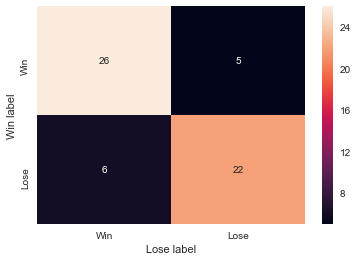

In [222]:
sns.heatmap(dfmat,annot=True)
plt.ylabel('Win label')
plt.xlabel('Lose label')
plt.show()

In [223]:
Precision = float(dfmat.iloc[0,0]) / (float(dfmat.iloc[0,0] + dfmat.iloc[0,1]))
Precision
Recall = float(dfmat.iloc[0,0]) / (float(dfmat.iloc[0,0] + dfmat.iloc[1,0]))
Recall
print """    De los partidos que hemos clasificados como ganadores, el %f tuvieron ese resultado. En total clasificamos 
correctamente el %f, de todos los partidos con categoría ganador. """ %(Precision, Recall)


    De los partidos que hemos clasificados como ganadores, el 0.838710 tuvieron ese resultado. En total clasificamos 
correctamente el 0.812500, de todos los partidos con categoría ganador. 


In [224]:
F1score = (2*float(dfmat.iloc[0,0]))/((2*float(dfmat.iloc[0,0])+float(dfmat.iloc[0,1])+float(dfmat.iloc[1,0])))
F1score

0.8253968253968254

     Este sería el punto óptimo de la curva precisión-recall. El F1 score, coincide practicamente con el accuracy score obtenido anteriormente.

**Vamos a dibujar la precision-recall curve:**

In [211]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

In [212]:
y_score = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

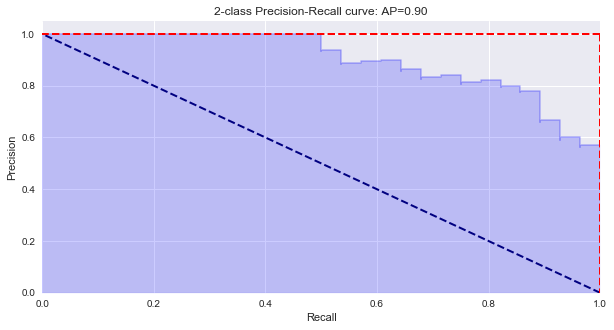

In [213]:
plt.figure(figsize=(10,5))
precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.plot([1, 0], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot([1, 0], [1, 1], color='red', lw=2, linestyle='--')
plt.plot([1, 1], [1, 0], color='red', lw=2, linestyle='--')
plt.show()

     Como vimos con anterioridad, el punto de la curva 0.838 , 0.8125 que arroja el modelo como óptimo corresponde al vértice de la curva.
     La linea roja es AUC=1 o valor de diagnostico perfecto, mientras que la linea morada es AUC=0.90 o el diagnostico del modelo de test. Un diagnostico superior al 0.75 se puede considerar bueno. Un diganostico del 0.90 significa que hay un 90% más de probabilidades de que nuestra clasificación sea correcta que si hicieramos una elección al azar (AUC=0.50, linea azul)